# Lab 4: Reading Sign Language with Convolutional Networks
CNNs have revolutionalized basically every problem that takes an image as input, and the simplest of these is image classification.

This project involves using TensorFlow and Keras to build a program that recognizes numbers 0-9 in sign language by classifying images of hands signing those digits.

## Section 0: Download the data
The data is available on Kaggle, at https://www.kaggle.com/ardamavi/sign-language-digits-dataset/.
You'll need an account to download it; let me know if you can't do this.

Make a directory called `data`, then unzip the data files inside that directory.
Your final directory structure should contain files:
 - `.../lab_4_cnn/data/X.npy`
 - `.../lab_4_cnn/data/Y.npy`

## Section 1: Understand the data
I've taken care of loading the data for you.
Read through the code (especially comments) so you understand what it does, and check out the plots.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
x_all = np.load('data/X.npy')
y_all = np.load('data/Y.npy')

In [3]:
# For whatever reason, the data's labels aren't the actual
# numbers depicted. This box fixes that.
# Real-world data is usually messy; this is one example.

# Maps dataset-provided label to true label
label_map = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}

# Correct dataset labels
for row in range(y_all.shape[0]):
    dataset_label = np.where(y_all[row])[0][0]
    y_all[row, :] = np.zeros(10)
    y_all[row, label_map[dataset_label]] = 1

In [4]:
# Seed numpy rng for reproducibility
np.random.seed(1337)

# Shuffle features and targets together
# Credit for this technique to:
# https://stackoverflow.com/questions/4601373/
# better-way-to-shuffle-two-numpy-arrays-in-unison
rng_state = np.random.get_state()
np.random.shuffle(x_all)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

# Add a dummy channel axis to input images
x_all = np.expand_dims(x_all, axis=-1)

# Center and rescale data to the range [-1, 1]
x_all = x_all - 0.5
x_all = x_all * 2

# Create a validation set from 30% of the available data
n_points = x_all.shape[0]
n_test = int(n_points * 0.3)
n_train = n_points - n_test
x_train, x_test = np.split(x_all, [n_train], axis=0)
y_train, y_test = np.split(y_all, [n_train], axis=0)

In [5]:
# Print important shapes in the dataset
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1444, 64, 64, 1)
x_test shape: (618, 64, 64, 1)
y_train shape: (1444, 10)
y_test shape: (618, 10)


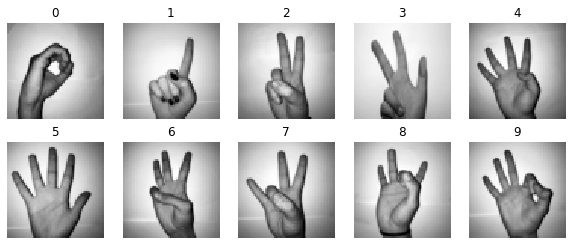

In [6]:
### Plot the first example of each digit in the training set.
### You don't need to understand the code, just look at the output.

# Set up plots
plots = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
axes_list = plots[1].ravel()

for digit in range(10):
    axes = axes_list[digit]
    axes.set_axis_off()
    axes.set_title(digit)
  
    # Find the index of the first appearance of this digit
    idx = np.where(y_train[:, digit] == 1)[0][0]
    
    # Plot the image
    axes.imshow(x_train[idx, :, :, 0],
                cmap='gray')

## Section 2: Build a TensorFlow data pipeline
Set up any `tf.data.Dataset` and `tf.data.Iterator` objects you need.

I used two `Dataset`s and a single reinitializable `Iterator`, but there are multiple ways to solve this problem.

In [7]:
# Your code here
print('x_all.shape: ', x_all.shape)
print('y_all.shape: ', y_all.shape)
x_all = tf.cast(x_all, dtype=tf.float64)
y_all = tf.cast(y_all, dtype=tf.float64)
x_train = tf.cast(x_train, dtype=tf.float64)
y_train = tf.cast(y_train, dtype=tf.float64)
x_test = tf.cast(x_test, dtype=tf.float64)
y_test = tf.cast(y_test, dtype=tf.float64)
n_epochs = 50
batch_size = 32
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))\
    .shuffle(500).batch(batch_size).cache()
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))\
    .shuffle(500).batch(batch_size).cache()
print('dataset_train: ', dataset_train)
print('dataset_test: ', dataset_test)
iterator = tf.data.Iterator.from_structure(
    dataset_train.output_types, 
    dataset_train.output_shapes)
print('iterator: ', iterator)
train_init_op = iterator.make_initializer(dataset_train)
test_init_op = iterator.make_initializer(dataset_test)

x_all.shape:  (2062, 64, 64, 1)
y_all.shape:  (2062, 10)
dataset_train:  <DatasetV1Adapter shapes: ((?, 64, 64, 1), (?, 10)), types: (tf.float64, tf.float64)>
dataset_test:  <DatasetV1Adapter shapes: ((?, 64, 64, 1), (?, 10)), types: (tf.float64, tf.float64)>
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
iterator:  <tensorflow.python.data.ops.iterator_ops.Iterator object at 0x102efb780>
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.


In [8]:
### Note the data type!!!

## Section 3: Build a model graph
We'll be building a fairly "traditional" image-processsing CNN: a few layers of 2-D convolutions and max pooling, then flattening, dense layers, and an output layer.

Feel free to experiment with the model architecture.
With a simple network, expect around 90% accuracy.
(Logistic regression gets about 75%).

### 3.1: Input tensors
Get a tensor for the input image and another for the correct label.
Note that the label is already one-hot encoded.

In [9]:
# Your code here
with tf.name_scope('inputs'):
    next_elem = iterator.get_next()
    features, target = next_elem
print(features.shape, features.dtype)
print(target.shape, target.dtype)

(?, 64, 64, 1) <dtype: 'float64'>
(?, 10) <dtype: 'float64'>


### 3.2: Helper function to make dense layers
Copy the `make_dense_layer()` function you wrote last week here, since this model will need dense layers too.

(In practice, we'd use `tf.layers.Dense`, which does basically the same thing, but using your code from last week gives you more flexibility to do things like plot histograms with minimal extra work).

In [10]:
def make_dense_layer(prev_activations, dim_input, dim_output, 
                     do_activation=True, postfix=''):
    '''
    Adds a dense layer to the model graph.
    
    Parameters
    ----------
    prev_activations: tensor
        The activations of the previous layer, or 
        the input for the first dense layer.
    dim_input: int
        Number of features in the input representation.
    dim_output: int
        Number of features in the output representation.
        Equivalently, number of units in this layer.
    do_activation: bool
        Whether or not to apply ReLU activation.
    postfix: string
        Postfix on name and variable scopes in this layer.
        Used to simplify visualizations.
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
#     with tf.name_scope('dense' + postfix):
#         with tf.variable_scope('dense' + postfix):
#             # Define variables here
#         # Define operations here
    #print(prev_activations.shape)
    with tf.name_scope('dense' + postfix):
        with tf.variable_scope('dense' + postfix): #postfix
            # Define variables here
            weights = tf.get_variable('weights'+ postfix, shape=(dim_input,dim_output), dtype=tf.float64,
                                      initializer=tf.glorot_uniform_initializer())
            bias = tf.get_variable('bias'+ postfix, shape=(1,dim_output), dtype=tf.float64,
                                   initializer=tf.zeros_initializer())
        # Define operations here
        output1 = tf.cast(tf.matmul(prev_activations,weights) + bias,tf.float64)
        if do_activation:
            output2 = tf.cast(tf.nn.relu(output1),tf.float64)
        else:
            output2 = output1
        print('output.shape: ', output2.shape)
        return output2

### 3.3: Helper function to make convolutional layers
Write a function, similar to `make_dense_layer()`, called `make_conv_layer()`, which has its signatures and scopes defined as a stub below.
When called, it should:
 1. Add variables named `filters` and `biases`, of appropriate shapes, to the graph.
 2. Compute the 2-D discrete convolution of `filter` over `input_` using `tf.nn.conv2d`, using the correct filter size and strides, and add in the bias.
 3. If `do_activation`, apply ReLU activation using `tf.nn.relu`.
 4. If `add_summary`, then create a new 1-channel `tf.summary.image()`s for each channel of the activation (pre-pooling). This will allow us to visualize the activation maps of various filters throughout training. Note that each image needs a channel dimension, though it should be 1 here.
 5. If `pool_size > 1`, uses `tf.nn.max_pool` to perform max pooling on the width and height axes.
 6. Return the activations if `do_activation`, or the pre-activation otherwise.
 
Hints:
 - Read [the tf.nn.conv2d documentation](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) extensively! It tells you what shapes your variables need to have.
 - The layer will have one kernel per input channel, and one bias per output channel
 - The `conv2d` strides should always be 1 in the batch and channel axes
 - In `max_pool`, the arguments `ksize` and `strides` will be the same
 - `padding` can be either 'SAME' or 'VALID'. I used 'SAME'. 

In [11]:
def make_conv_layer(input_, input_channels, n_filters,
                    filter_size=3, stride=1, 
                    do_activation=True, pool_size=1,
                    add_summary=False, postfix=''):
    '''
    Adds a convolutional layer to the model graph.
    
    Parameters
    ----------
    input_: tensor
        The activations of the previous layer, or 
        the input for the first dense layer.
    input_channels: int
        Number of channels in the input representation.
    n_filters: int
        Number of channels in the output representation.
        Equivalently, number of filters in this layer.
    filter_size: int
        Width and height of each kernel in the layer's filters.
    stride: int
        Stride to use in the x and y directions for the
        convolution operation.
    do_activation: bool
        Whether or not to apply ReLU activation.
    pool_size: int
        If > 1, does max pooling of this size to the
        width and height axes of the activation.
    add_summary: bool
        Whether or not to log activations as summary images.
    postfix: string
        Postfix on name and variable scopes in this layer.
        Used to simplify visualizations.
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
    print('conv' + postfix, input_.shape)
    with tf.name_scope('conv' + postfix):
        with tf.variable_scope('conv' + postfix):
            filters = tf.get_variable('filter'+ postfix, shape=(filter_size, filter_size,input_channels, n_filters), dtype=tf.float32,
                                      initializer=tf.glorot_uniform_initializer())
            bias = tf.get_variable('bias'+ postfix, shape=(input_.shape[1], input_.shape[2], n_filters), dtype=tf.float32,
                                   initializer=tf.zeros_initializer())
            pass # Define variables here
        
        output1 = tf.cast(tf.nn.conv2d(tf.cast(input_,tf.float32), filters, [1,1,1,1], padding='SAME') + bias, dtype=tf.float32)
        #!!!
        
        if do_activation:
            output2 = tf.cast(tf.nn.relu(output1),tf.float32)
        else:
            output2 = output1
        
        if add_summary:
            print('summary: ',tf.transpose(tf.expand_dims(output2[0],axis=-1),perm=[2,0,1,3]).shape)
            #print('summary: ',np.expand_dims(tf.transpose(output2[0,:,:,:],perm=[1,2,0]),axis=-1).shape)
            tf.summary.image('im', tf.transpose(tf.expand_dims(output2[0],axis=-1),perm=[2,0,1,3])) #???
        
        if pool_size>1:
            output3 = tf.cast(tf.nn.max_pool(output2, ksize=[1, pool_size,pool_size, 1], strides=[1,stride,stride,1], padding='SAME'),tf.float64)
        else:
            output3 = tf.cast(output2,tf.float64)
        
        print('output.shape: ', output3.shape)
        return output3
        pass # Define operations here 
    

In [12]:
#hidden_layer_x = make_conv_layer(hidden_layer_1, input_channels=16, n_filters=32, filter_size=5, 
#                                 stride=2, do_activation=True, pool_size=2, add_summary=True, postfix='aabaaaa')

### 3.4: Make the feature-extraction layers
Now for the fun part.
Use `make_conv_layer()` and `make_dense_layer()` to make the main part of the model.
Set `add_summary=True` for at least one convolutional layer.

Hints:
 - Try some layers with convolution and max pooling, then flatten (using `tf.reshape`) and add dense layers
 - The first convolutional layer has 1 input channel
 - The input is 64x64, so do lots of downsampling with strides and max pooling before you switch to dense layers to prevent having a huge number of parameters. (If you don't downsample at all, use 32 filters in the last convolutional layer, and use 128 units in the first dense layer, there will be 64\*64\*32\*128 = ~17 million parameters in that dense layer alone! The whole model should ideally have less than 1 million parameters.)
 - If you're having trouble designing a model, try doing it in Keras first and visualizing the shapes and parameters with `model.summary()`

In [13]:
# Your code here
hidden_layer_1 = make_conv_layer(features, input_channels=1, n_filters=16, filter_size=5, 
                                 stride=1, do_activation=True, pool_size=1, add_summary=False, postfix='h1')
hidden_layer_2 = make_conv_layer(hidden_layer_1, input_channels=16, n_filters=16, filter_size=5, 
                                 stride=2, do_activation=True, pool_size=2, add_summary=True, postfix='h2')
hidden_layer_3 = make_conv_layer(hidden_layer_2, input_channels=16, n_filters=32, filter_size=5, 
                                 stride=1, do_activation=True, pool_size=1, add_summary=False, postfix='h3')
hidden_layer_4 = make_conv_layer(hidden_layer_3, input_channels=32, n_filters=32, filter_size=5, 
                                 stride=1, do_activation=True, pool_size=1, add_summary=False, postfix='h4')
hidden_layer_5 = make_conv_layer(hidden_layer_3, input_channels=32, n_filters=32, filter_size=5, 
                                 stride=2, do_activation=True, pool_size=2, add_summary=False, postfix='h5')
hidden_layer_6 = make_conv_layer(hidden_layer_5, input_channels=32, n_filters=32, filter_size=5, 
                                 stride=2, do_activation=True, pool_size=2, add_summary=False, postfix='h6')

hidden_layer_7 = make_dense_layer(tf.reshape(hidden_layer_6,(-1,2048)),2048,128,do_activation=True,postfix='h7')



convh1 (?, 64, 64, 1)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
output.shape:  (?, 64, 64, 16)
convh2 (?, 64, 64, 16)
summary:  (16, 64, 64, 1)
output.shape:  (?, 32, 32, 16)
convh3 (?, 32, 32, 16)
output.shape:  (?, 32, 32, 32)
convh4 (?, 32, 32, 32)
output.shape:  (?, 32, 32, 32)
convh6 (?, 32, 32, 32)
output.shape:  (?, 16, 16, 32)
convh7 (?, 16, 16, 32)
output.shape:  (?, 8, 8, 32)
output.shape:  (?, 128)


In [14]:
tf.reshape(hidden_layer_5,(-1,2048)).shape
hidden_layer_5.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(32)])

### 3.5: Compute logits
Use `make_dense_layer()` to make a final dense layer with `dim_output=10` and no activation to compute the final per-class logits.

In [15]:
# Your code here
logits = make_dense_layer(hidden_layer_7,128,10,do_activation=False,postfix='logits') #logits


output.shape:  (?, 10)


### 3.6: Compute class probability for output
Use `tf.nn.softmax` to compute the class probabilities.
We will not use this for the loss, just for the output.

In [16]:
# Your code here
class_probabilities = tf.nn.softmax(logits)
print(class_probabilities.shape)

(?, 10)


### 3.7: Compute cross-entropy loss
Use `tf.nn.softmax_cross_entropy_with_logits_v2()` to compute the per-example loss, then `tf.reduce_mean()` to compute the mean loss for the batch.

Add a summary scalar to plot loss in TensorBoard, and assign it to a variable since this time we'll need it later.

In [17]:
# Your code here
#cross_entropy_per_example = tf.nn.softmax_cross_entropy_with_logits_v2(labels=target,logits=logits)
cross_entropy_per_example = -tf.reduce_sum(target*tf.log(class_probabilities),axis=1)
print(cross_entropy_per_example.shape)
cross_entropy_batch = tf.reduce_mean(cross_entropy_per_example)
print(cross_entropy_batch.shape)

(?,)
()


In [18]:
target.shape

TensorShape([Dimension(None), Dimension(10)])

In [19]:
tf.summary.scalar('loss', cross_entropy_batch)

<tf.Tensor 'loss:0' shape=() dtype=string>

### 3.8: Optimizer and gradients
Make an optimizer (I used `tf.train.MomentumOptimizer` with `lr=1e-3` and `momentum=0.9`) and an operation to apply the gradients (either `optimizer.minimize()`, or compute the gradients manually).

In [20]:
# Your code here
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-3, momentum=0.9)
optimize_step = optimizer.minimize(cross_entropy_batch)

### 3.9: Predicted digit and per-batch accuracy
The model should predict the digit it assigns the highest probability.
Then, add a tensor which represents what fraction of the batch the model predicted correctly (its accuracy, or average 0/1 loss), and a summary operation for accuracy.

Finally, add a tensor to merge the summaries made so far.

Hint: to get the numerical value from the one-hot encoded label, use `tf.argmax`.

In [21]:
# Your code here
pred_label = tf.argmax(class_probabilities,axis=1)
print(pred_label.shape)
correctness = tf.equal(pred_label, tf.argmax(target,axis=1))
print(correctness.shape)
accuracy = tf.reduce_mean(tf.cast(correctness,tf.float64))
print(accuracy.shape)

(?,)
(?,)
()


In [22]:
print(pred_label.dtype)
print(accuracy.dtype)

<dtype: 'int64'>
<dtype: 'float64'>


## Section 4: train the model
Same training loop as always, with one small modification: you don't want to save every summary every batch because the `tf.summary.image()` operations save images.
Run the loss summary operation every batch.


Only run the full `tf.summary.merge_all()` operation once per every few batches, and when you do, use `feed_dict` to overwrite your input tensors with a "batch" of a single example (the same one every time).
This will let you visualize in the TensorBoard Images tab how the activation maps of various filters on that one example change as the network trains.

In [23]:
# Your code here
# Training code
saver = tf.train.Saver() # Save varibles
merged_summaries = tf.summary.merge_all() # Single merged summary op

n_epochs = 30
batch_size = 32

train_batch = 0
test_batch = 0

with tf.Session() as sess:
    # Make one writer for training logs and another for test logs 
    train_writer = tf.summary.FileWriter('./logs_lab/train', graph=sess.graph)
    test_writer = tf.summary.FileWriter('./logs_lab/test')
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Training loop
    for epoch in range(n_epochs):
        # Load training data
        sess.run(train_init_op)
        
        # Iterate over the dataset once
        while True:
            try:
                if train_batch > 0: # Typical batch
                    # Run summary ops and optimization
                    summary, _ = sess.run([merged_summaries, optimize_step])
                    train_writer.add_summary(summary, train_batch)
                    train_batch += 1
                else:
                    # On the first batch, run a full trace
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                    run_metadata = tf.RunMetadata()
                    
                    summary, _ = sess.run([merged_summaries, optimize_step],
                                          options=run_options,
                                          run_metadata=run_metadata)
                    
                    train_writer.add_summary(summary, train_batch)    
                    train_writer.add_run_metadata(run_metadata, 
                                                  'first training batch')
                    train_batch += 1
            except tf.errors.OutOfRangeError: # No more data
                break
    
        
        print('Epoch:', epoch)
        sess.run(test_init_op)
        accuracies = [] # Track average loss over test set
        while True:
            try:
                summary, pred_accuracy = sess.run([merged_summaries, accuracy])
                accuracies.append(pred_accuracy)

                # Roughly align test batches with training batches
                test_writer.add_summary(summary, test_batch)
                test_batch += 1
            except tf.errors.OutOfRangeError:
                break
        average_accuracy = np.mean(accuracies)
        print('Average test set accuracy:', average_accuracy)
        
    # Save model
    saver.save(sess, './checkpoints_lab/model.ckpt')

Epoch: 0
Average test set accuracy: 0.0978125
Epoch: 1
Average test set accuracy: 0.1565625
Epoch: 2
Average test set accuracy: 0.23531249999999998
Epoch: 3
Average test set accuracy: 0.3275
Epoch: 4
Average test set accuracy: 0.586875
Epoch: 5
Average test set accuracy: 0.7325
Epoch: 6
Average test set accuracy: 0.7584375
Epoch: 7
Average test set accuracy: 0.8121875
Epoch: 8
Average test set accuracy: 0.8559374999999999
Epoch: 9
Average test set accuracy: 0.85625
Epoch: 10
Average test set accuracy: 0.8734375
Epoch: 11
Average test set accuracy: 0.8996875
Epoch: 12
Average test set accuracy: 0.878125
Epoch: 13
Average test set accuracy: 0.909375
Epoch: 14
Average test set accuracy: 0.8890625
Epoch: 15
Average test set accuracy: 0.9109375
Epoch: 16
Average test set accuracy: 0.898125
Epoch: 17
Average test set accuracy: 0.9071875
Epoch: 18
Average test set accuracy: 0.9246874999999999
Epoch: 19
Average test set accuracy: 0.9121874999999999
Epoch: 20
Average test set accuracy: 0.915312

## Section 5: visualization
Run TensorBoard, go to the Images tab, and look at how the final activation maps in various layers differ from each other, and (by dragging the slide bar at the top of each) how the activation map of a single filter develops as the network trains.

This is what some activation maps of my first-layer, size-5 convolutions look like:
![First-layer activations](./images/conv_outs.png)

I see some interesting results here.
The first and fourth filters seem to be activating on the background, the second detects the outside edges of the hand, and the third activates for sharp vertical gradients.

Second-layer activation maps are a little more abstract, but still mostly make sense:
![Second-layer activations](./images/conv_outs_2.png)
The first one is really interesting, it seems to detect areas of high complexity in the image.

My fourth-layer activation maps are too abstract to make any sense of:
![Fourth-layer activations](./images/conv_outs_3.png)